In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import soundfile as sf
from lib import *

In [4]:
# Initialize lists to store audio data and sample rates
rir = np.zeros((2, 21, 6), dtype=object) # room impluse response
sr = np.zeros((2, 21, 6), dtype=object) # sample rate

# Load audio files
folder = './RIRs/'
for i in range(1, 3):  # speaker
    for j in range(0, 21):  # position
        for k in range(1, 7):  # microphone
            if j < 10:
                file_path = os.path.join(folder,f's{i}_p0{j}_m{k}.wav')
            else:
                file_path = os.path.join(folder,f's{i}_p{j}_m{k}.wav')
            rir[i-1, j, k-1], sr[i-1, j, k-1] = sf.read(file_path)

sr = sr[0,0,0]

(0.0, 0.05)

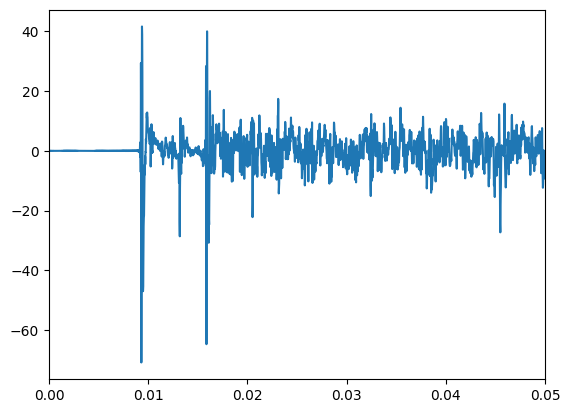

In [11]:
s = rir[0,20,0]
time = np.arange(0, len(s)) / sr
plt.plot(time, s)
plt.xlim([0,0.05])


In [31]:
s = rir[0,0,0][0:2000]
t = rir[0,2,0][0:2000]
ref = rir[0,1,0][0:2000]
time = np.arange(0, len(s)) / sr
dtw_matrix = cal_dtw_matrix(s,t)

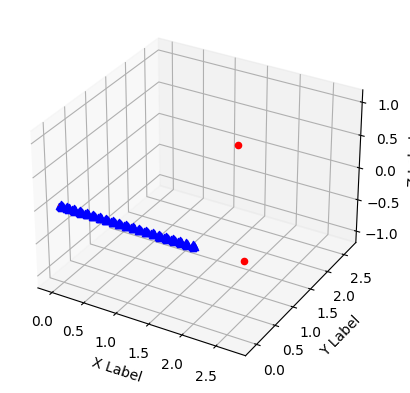

In [32]:
# Create positions for mics and speakers in meters
p_speaker1 = np.array([1.2, 2.6, 0])
p_speaker2 = np.array([0.34+2.39, 0, 0])
p_mic = np.zeros((21, 6), dtype=object)
Radius = 0.025  # 25 mm
for j in range(0, 21):  # position
    p_center = np.array([j, 0, 0])*0.1
    p_mic[j, 0] = p_center + np.array([0, -Radius, 0 ])
    p_mic[j, 1] = p_center + np.array([0, Radius, 0])
    p_mic[j, 2] = p_center + np.array([-Radius, 0, 0])
    p_mic[j, 3] = p_center + np.array([Radius, 0, 0])
    p_mic[j, 4] = p_center + np.array([0, 0, Radius])
    p_mic[j, 5] = p_center + np.array([0, 0, -Radius])

# plot all mics and speakers
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, c='r', marker='*')
ax.scatter(p_speaker1[0], p_speaker1[1], p_speaker1[2], c='r', marker='o')
ax.scatter(p_speaker2[0], p_speaker2[1], p_speaker2[2], c='r', marker='o')
for i in range(0, 21):
    for j in range(0, 6):
        ax.scatter(p_mic[i, j][0], p_mic[i, j][1], p_mic[i, j][2], c='b', marker='^')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')
plt.show()

In [33]:
d_s = np.linalg.norm(p_mic[0, 0] - p_speaker1)
d_t = np.linalg.norm(p_mic[2, 0] - p_speaker1)
d_i = np.linalg.norm(p_mic[1, 0] - p_speaker1)
alpha = (1/d_t-1/d_i)/(1/d_t-1/d_s)

(2001, 2001)


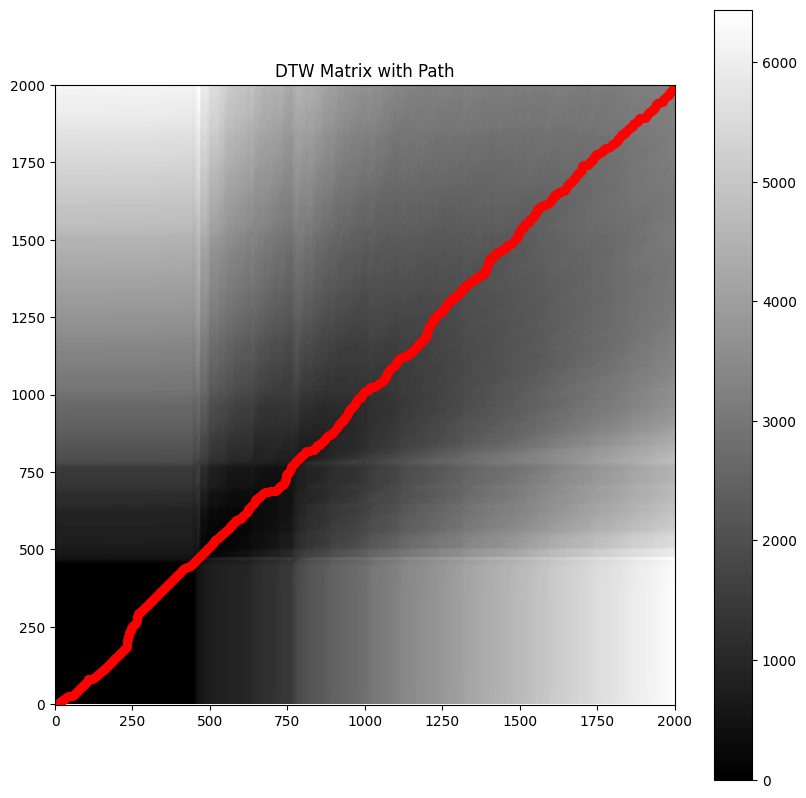

In [34]:
# Assuming cal_dtw_matrix returns both dtw_matrix and path
dtw_matrix, path = cal_dtw_matrix(s, t)

# Print the shape of the dtw_matrix
print(dtw_matrix.shape)

# Plot dtw matrix and show the path
plt.figure(figsize=(10, 10))
plt.imshow(dtw_matrix, origin='lower', cmap='gray')  # Use 'gray' colormap for better visibility

# Highlight the path on the plot
plt.plot(path[:, 1], path[:, 0], color='r', marker='o', markersize=5)

plt.colorbar()
plt.title('DTW Matrix with Path')
plt.show()

In [57]:
path[0:6]

array([[0, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5]])

In [62]:
s_warp_vec = path[:,0]
t_warp_vec = path[:,1]

s_warp = np.array([])
t_warp = np.array([])

# # Extract warped sequences based on the optimal path
for i in range(0, len(s_warp_vec)):
    s_warp = np.append(s_warp, s[s_warp_vec[i]-1])
    t_warp = np.append(t_warp, t[t_warp_vec[i]-1])

i_warp = s_warp * alpha + t_warp * (1 - alpha)

In [63]:
beta = (d_i - d_t)/(d_s - d_t)


In [49]:
# Calculate the warping vector_s by dividing the elements of s_warp by the corresponding elements of s
warp_vector_s = np.array(s_warp)[-2000:] / np.array(s)
warp_vector_t = np.array(t_warp)[-2000:] / np.array(t)

beta = (d_i - d_t)/(d_s - d_t)
warp_vector_i = beta * warp_vector_s + (1 - beta) * warp_vector_t

i_unwarp = i_warp[-2000:] / warp_vector_i
# shift the unwarp signal to the left and add zeros to the right
shift = len(path)-len(s)
i_unwarp = np.concatenate((i_unwarp[shift:], np.zeros(shift)))

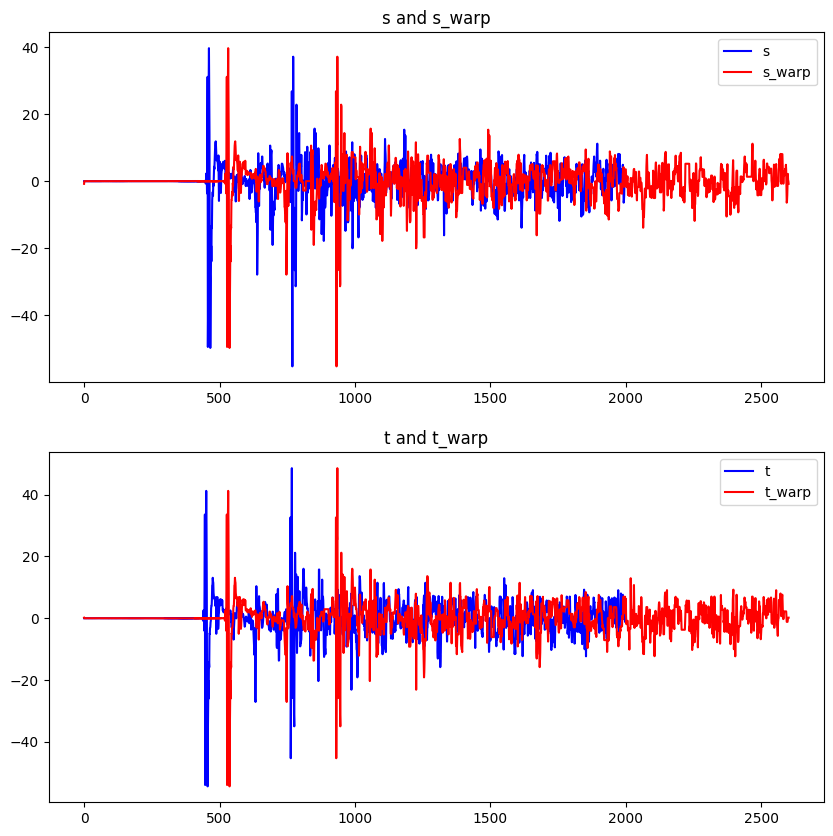

In [64]:
# plot s and s_warp and t and t_warp
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(s, color='b', label='s')
plt.plot(s_warp, color='r', label='s_warp')
plt.legend()
plt.title('s and s_warp')

plt.subplot(2, 1, 2)
plt.plot(t, color='b', label='t')
plt.plot(t_warp, color='r', label='t_warp')
plt.legend()
plt.title('t and t_warp')
plt.show()

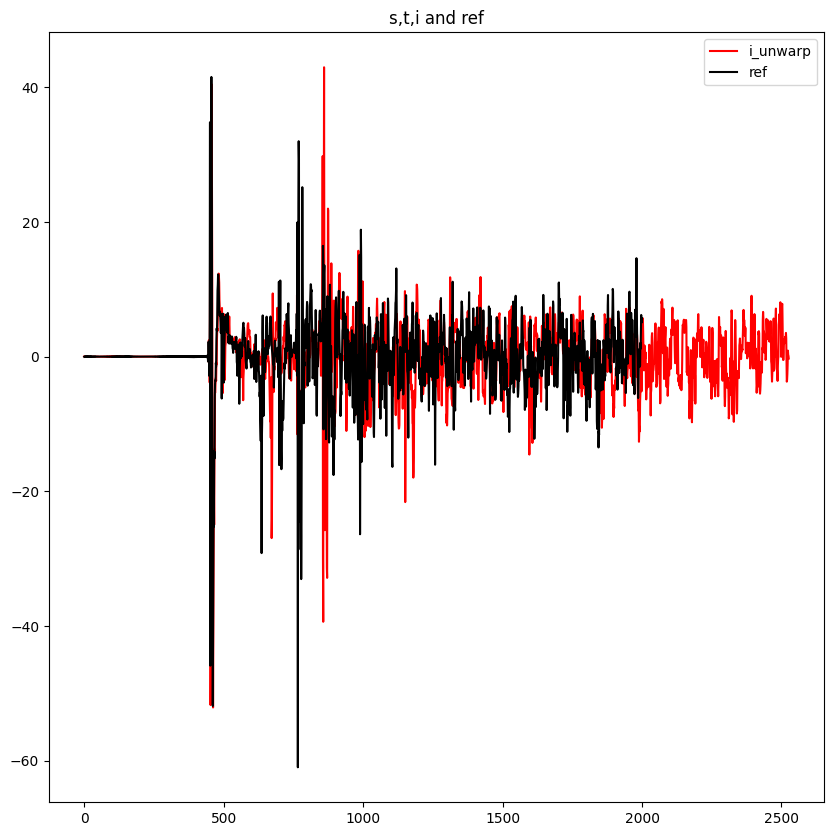

In [68]:
# plot s,t,i and ref
plt.figure(figsize=(10, 10))
# plt.plot(s, color='b', label='s')
# plt.plot(t, color='g', label='t')
plt.plot(i_warp[75:], color='r', label='i_unwarp')
plt.plot(ref, color='k', label='ref')
plt.legend()
plt.title('s,t,i and ref')
plt.show()